## Tasks

**Before you start**: open [gradescope](https://www.gradescope.com/) and respond with your initial predictions.

In this notebook we'll be using a new (to us) dataset, and you'll compare the performance of several models. Your end goal is to acheive the highest accuracy you have the patience to attain. You will

1. Train a ten-neuron network without any hidden layers or activations. The notebook is already setup to do so, you need only run all cells.

1. Train a fully connected neural network with multiple hidden layers. You'll only need to change the `neurons_per_hidden_layer` variable.

1. Create and train a convolutional neural network. A good place to start is [this tutorial form PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network). The most difficult part is getting the output of the convolutional layers to match the input of the fully connected (linear) layers. Your best tools include: (1) error messages talking about shapes, (2) the call to `summary(model)`, and (3) hand computing the shape of each layer's output.

1. Try including [dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) and/or [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) layers.

1. Tune the Adam optimizer (pass in some parameters).

1. Try one of the models [provided by torchvision](https://pytorch.org/vision/stable/models.html). For example:

~~~python
from torchvision.models import resnet18
model = resnet18(num_classes=num_classes).to(device)
~~~

This notebook contains several "TODO" comments. Search these out when trying to tune hyperparameters.

## Imports

In [45]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from fastprogress.fastprogress import master_bar, progress_bar
from jupyterthemes import jtplot
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import make_grid

jtplot.style(context="talk")

## Dataset Utility

In [46]:
def get_cifar10_data_loaders(path, batch_size, valid_batch_size=0):

    # Data specific transforms
    data_std = (0.2470, 0.2435, 0.2616)
    data_mean = (0.4914, 0.4822, 0.4465)
    xforms = Compose([ToTensor(), Normalize(data_mean, data_std)])

    # Training dataset and loader
    train_dataset = CIFAR10(root=path, train=True, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    valid_dataset = CIFAR10(root=path, train=False, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

## Training Utility

In [47]:
def train_one_epoch(mb, loader, device, model, criterion, optimizer):

    model.train()

    losses = []

    num_batches = len(loader)
    dataiterator = iter(loader)

    for batch in progress_bar(range(num_batches), parent=mb):

        mb.child.comment = "Training"

        # Grab the batch of data and send it to the correct device
        X, Y = next(dataiterator)
        X, Y = X.to(device), Y.to(device)

        # Compute the output
        output = model(X)

        # Compute loss
        loss = criterion(output, Y)
        losses.append(loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

## Validation Utility

In [48]:
def validate(mb, loader, device, model, criterion):

    model.eval()

    losses = []
    num_correct = 0

    num_classes = len(loader.dataset.classes)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    N = len(loader.dataset)
    num_batches = len(loader)
    dataiterator = iter(loader)

    with torch.no_grad():

        batches = range(num_batches)
        batches = progress_bar(batches, parent=mb) if mb else batches
        for batch in batches:

            if mb:
                mb.child.comment = f"Validation"

            # Grab the batch of data and send it to the correct device
            X, Y = next(dataiterator)
            X, Y = X.to(device), Y.to(device)

            output = model(X)

            loss = criterion(output, Y)
            losses.append(loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = output.argmax(dim=1)

            # Sum up total number that were correct
            comparisons = predictions == Y
            num_correct += comparisons.type(torch.float).sum().item()

            # Sum up number of correct per class
            for result, clss in zip(comparisons, Y):
                class_correct[clss] += result.item()
                class_total[clss] += 1

    accuracy = 100 * (num_correct / N)
    accuracies = {
        clss: 100 * class_correct[clss] / class_total[clss]
        for clss in range(num_classes)
    }

    return losses, accuracy, accuracies

## Loss Plotting Utility

In [49]:
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

## Data Loading

In [50]:
# TODO: tune the training batch size
train_batch_size = 128

# Let's use some shared space for the data (so that we don't have copies
# sitting around everywhere)
data_path = "/data/cs152/cache/pytorch/data"

# Use the GPUs if they are available
# TODO: if you run into GPU memory errors you should set device to "cpu" and restart the notebook
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

valid_batch_size = 5000
train_loader, valid_loader = get_cifar10_data_loaders(
    data_path, train_batch_size, valid_batch_size
)

# Input and output sizes depend on data
num_features = torch.Size(train_loader.dataset.data.shape[1:]).numel()
class_names = train_loader.dataset.classes
num_classes = len(class_names)

print(class_names)

Using 'cuda:1' device.
Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


      frog      truck      truck       deer automobile automobile       bird      horse
      ship        cat       deer      horse      horse       bird      truck      truck
     truck        cat       bird       frog       deer        cat       frog       frog
      bird       frog        cat        dog       deer   airplane   airplane      truck
automobile        cat       deer   airplane        cat      horse        cat        cat
       dog       bird       bird      horse automobile automobile automobile       bird
      bird   airplane      truck        dog      horse      truck       bird       bird
       dog       bird       deer        cat automobile automobile       ship       bird


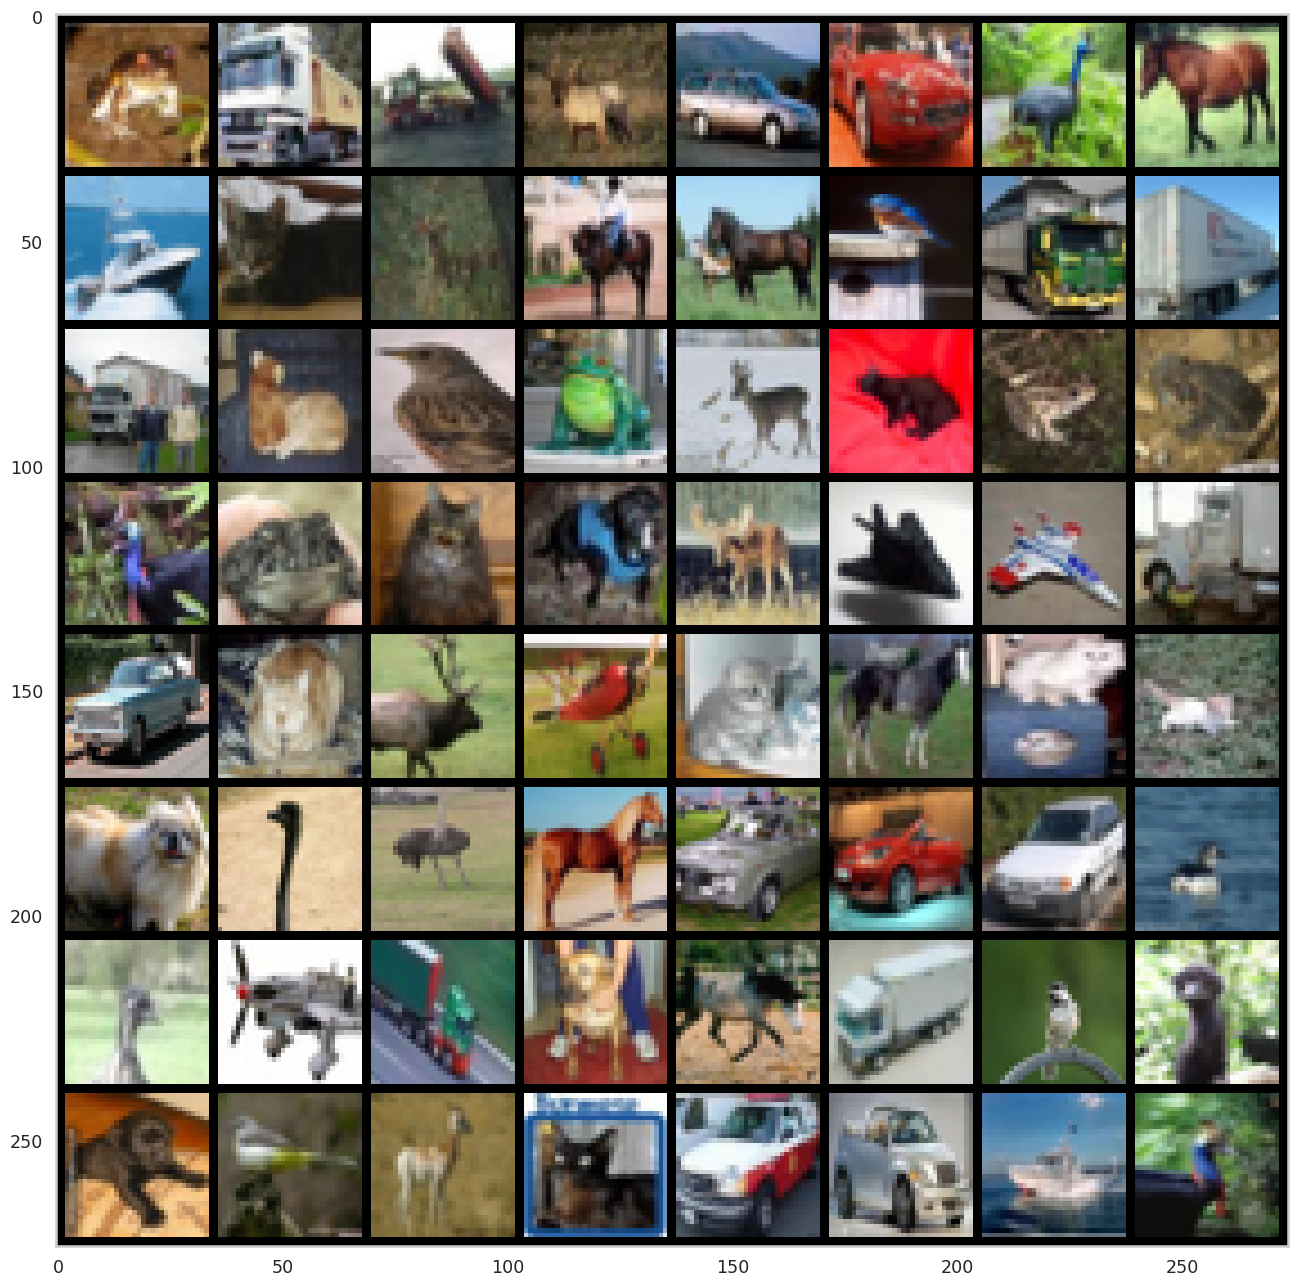

In [51]:
# Grab a bunch of images and change the range to [0, 1]
nprint = 64
images = torch.tensor(train_loader.dataset.data[:nprint] / 255)
targets = train_loader.dataset.targets[:nprint]
labels = [f"{class_names[target]:>10}" for target in targets]

# Create a grid of the images (make_grid expects (BxCxHxW))
image_grid = make_grid(images.permute(0, 3, 1, 2))

_, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image_grid.permute(1, 2, 0))
ax.grid(None)

images_per_row = int(nprint ** 0.5)
for row in range(images_per_row):
    start_index = row * images_per_row
    print(" ".join(labels[start_index : start_index + images_per_row]))

## Model Creation

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges an image into a column vector
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        # TODO: add dropout and/or batch normalization
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer, *hidden_layers, output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # TODO: create layers here
        
        # First [Conv2d -> ReLU] group of M=1
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        # Second [Conv2d -> ReLU] group of M=1
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        # First [Conv2d -> ReLU] group of M=2
        self.conv5 = nn.Conv2d(256, 128, 3)
        self.conv6 = nn.Conv2d(128, 64, 3)
        
        # Second [Conv2d -> ReLU] group of M=2
        self.conv7 = nn.Conv2d(64, 32, 3)
        self.conv8 = nn.Conv2d(32, 16, 3)
        
        # First [Linear -> ReLU] group of K=1
        #64 comes from the shape and number of filters in the last conv layer
        self.fc1 = nn.Linear(64, 32)
        
        #Second [Linear -> ReLU] group of K=1
        self.fc2 = nn.Linear(32, 16)
        
        # And finally, the output linear layer
        self.fc3 = nn.Linear(16, num_classes)

        # Early CNNs had the following structure:
        #    X -> [[Conv2d -> ReLU] x N -> MaxPool2d] x M
        #      -> [Linear -> ReLU] x K -> Linear
        #   Where
        #     0 ≤ N ≤ 3
        #     0 ≤ M ≤ 3
        #     0 ≤ K < 3
        #
        # The "[[Conv2d -> ReLU] x N -> MaxPool2d] x M" part extracts
        # useful features, and the "[Linear -> ReLU] x K -> Linear" part
        # performs the classification.

    def forward(self, X):

        # TODO: implement forward pass here
        # print("Input:", X.shape)
        X = F.relu(self.conv1(X))
        # print("After conv1:", X.shape)
        X = F.relu(self.conv2(X))
        # print("After conv2:", X.shape)
        X = F.max_pool2d(X, 2)
        # print("After max_pool:", X.shape)
        X = F.relu(self.conv3(X))
        # print("After conv3:", X.shape)
        X = F.relu(self.conv4(X))
        # print("After conv4:", X.shape)
        X = F.max_pool2d(X, 1)
        # print("After max_pool:", X.shape)
        X = F.relu(self.conv5(X))
        # print("After conv5:", X.shape)
        X = F.relu(self.conv6(X))
        # print("After conv6:", X.shape)
        X = F.max_pool2d(X, 1)
        # print("After max_pool:", X.shape)
        X = F.relu(self.conv7(X))
        # print("After conv7:", X.shape)
        X = F.relu(self.conv8(X))
        # print("After conv8:", X.shape)
        X =F.max_pool2d(X, 1)
        # print("After max_pool:", X.shape)
        X = X.view(X.shape[0], -1)
        # print("After reshape:", X.shape)
        X = F.relu(self.fc1(X))
        # print(X.shape)
        X = F.relu(self.fc2(X))
        # print(X.shape)
        X = self.fc3(X)
        # print(X.shape)

        return X

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [54]:
# TODO: try out different network widths and depths
neurons_per_hidden_layer = [20, 30, 30, 20]
layer_sizes = [num_features, *neurons_per_hidden_layer, num_classes]
# model = NeuralNetwork(layer_sizes).to(device)

# TODO: complete the CNN class in the cell above this one and then uncomment this line
# model = CNN().to(device)

# TODO: use an off-the-shell model from PyTorch
# from torchvision.models import ...
# model = Net().to(device)
from torchvision.models import resnet18
model = resnet18(num_classes=num_classes).to(device)

summary(model)

# TODO: try out different Adam hyperparameters
optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

## Training and Analysis

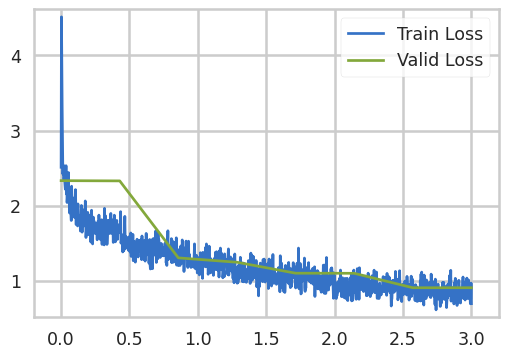

0.6957539916038513
0.9077735543251038


In [55]:
# TODO: tune the number of epochs
num_epochs = 3

train_losses = []
valid_losses = []
accuracies = []

# A master bar for fancy output progress
mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]
mb.main_bar.comment = f"Epochs"

# Loss and accuracy prior to training
vl, accuracy, _ = validate(None, valid_loader, device, model, criterion)
valid_losses.extend(vl)
accuracies.append(accuracy)

for epoch in mb:

    tl = train_one_epoch(mb, train_loader, device, model, criterion, optimizer)
    train_losses.extend(tl)

    vl, accuracy, acc_by_class = validate(mb, valid_loader, device, model, criterion)
    valid_losses.extend(vl)
    accuracies.append(accuracy)

    update_plots(mb, train_losses, valid_losses, epoch, num_epochs)

print(train_losses[-1])
print(valid_losses[-1])

Accuracy per class
      airplane: 75.0%
    automobile: 79.0%
          bird: 51.8%
           cat: 51.1%
          deer: 71.3%
           dog: 54.0%
          frog: 86.2%
         horse: 65.7%
          ship: 80.1%
         truck: 78.1%


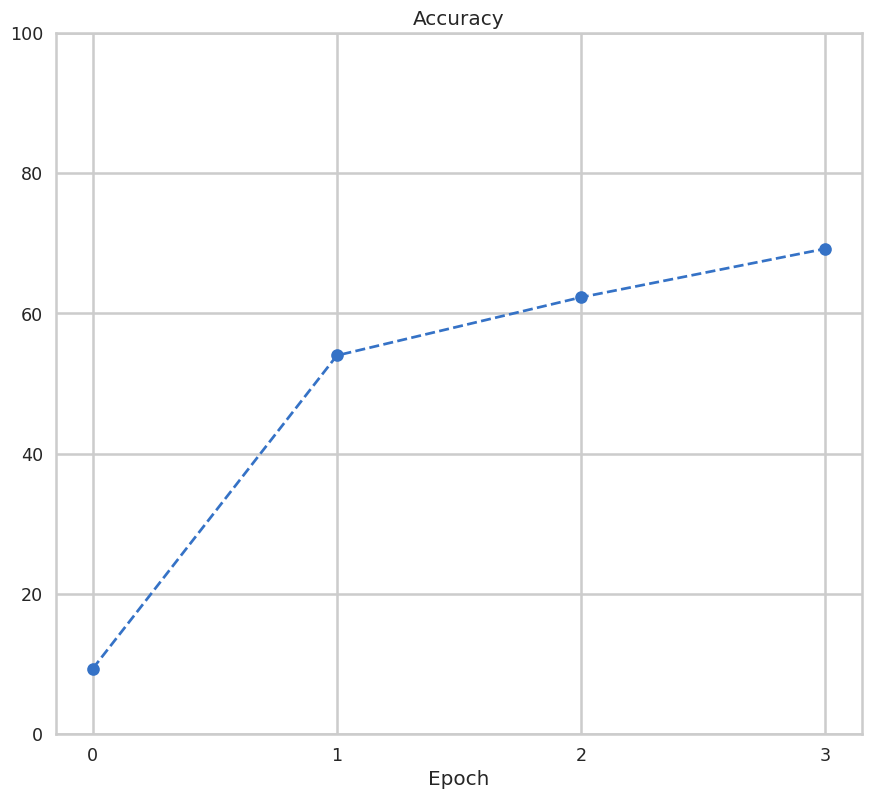

In [56]:
plt.plot(accuracies, '--o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.xticks(range(num_epochs+1))
plt.ylim([0, 100])

max_name_len = max(len(name) for name in class_names)

print("Accuracy per class")
for clss in acc_by_class:
    class_name = class_names[clss]
    class_accuracy = acc_by_class[clss]
    print(f"  {class_name:>{max_name_len+2}}: {class_accuracy:.1f}%")